In [29]:
%matplotlib inline


# 01 Data processing

This notebook imports standardized data from `df_2021.pkl` and define batch splits, part counts, runs PCA and creates lag features for further analyses.

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns

pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 20)
pd.set_option('display.precision', 3)

Load data. Define dataframe `df_X` of input features.

In [31]:
df = pd.read_pickle('df_2021.pkl') 

X_cols = [col for col in df.columns if 'x' in col]
df_X = df.loc[:,X_cols]
df_X = df_X.reset_index()
df_X.drop(columns=['timestamp'], inplace=True)
df_X

,x1,x2,x3,x4,x5,...,x96,x97,x98,x99,x100
0,-0.068,-0.403,-0.683,-0.810,0.990,...,2.641,-1.095,-0.525,-1.028,0.424
1,-0.068,-0.403,-0.683,-0.810,0.990,...,2.641,-1.095,-0.525,-1.028,0.424
2,0.015,-0.403,-1.024,-0.810,0.839,...,-0.557,-0.517,-0.179,0.050,1.483
3,0.015,-0.403,-1.024,-0.810,0.839,...,-0.557,-0.517,-0.179,0.050,1.483
4,-1.822,0.465,1.495,1.683,-0.687,...,2.797,1.344,1.802,-9.325,0.239
...,...,...,...,...,...,...,...,...,...,...,...
1233,-1.739,-0.315,-0.844,-0.810,0.990,...,0.566,-0.335,-0.218,1.111,0.558
1234,1.602,0.543,-0.485,0.125,-1.191,...,0.566,-0.831,-1.172,0.525,0.754
1235,1.602,0.543,-0.485,0.125,-1.191,...,0.566,-0.831,-1.172,0.525,0.754
1236,1.185,0.543,1.495,1.683,-0.687,...,0.566,1.657,0.985,-1.946,-0.154


Define dataframe `df_y` of label values and look for outliers

In [32]:
y_cols = [col for col in df.columns if 'y' in col]
df_y = df.loc[:,y_cols]
df_y = df_y.reset_index()
df_y.drop(columns=['timestamp'], inplace=True)

n_std = 4
m1 = (df_y > n_std).any(1) 
m2 = (df_y < -n_std).any(1)

df_outliers = df_y.loc[m1|m2]
row_absmax = df_outliers.abs().max(axis=1)
df_outliers['worst'] = row_absmax * (-1) ** df_outliers.ne(row_absmax, axis=0).all(axis=1) # Column of largest absolute values

print(len(df_outliers), 'outliers')
df_outliers


9 outliers


C:\Users\christiano\AppData\Local\Temp\ipykernel_28124\619809808.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outliers['worst'] = row_absmax * (-1) ** df_outliers.ne(row_absmax, axis=0).all(axis=1) # Column of largest absolute values


,y1,y2,y3,y4,y5,y6,worst
312,-4.397,0.214,0.112,0.873,0.228,0.870,-4.397
316,-4.397,0.177,0.112,0.566,0.228,0.870,-4.397
321,-4.397,0.210,0.138,0.621,-1.325,0.473,-4.397
350,4.657,0.318,0.345,-0.211,-0.725,0.870,4.657
383,5.261,-0.084,0.125,-1.766,-1.184,0.969,5.261
796,5.261,0.183,0.112,0.610,0.863,-0.521,5.261
799,-0.172,0.037,-0.070,0.906,0.333,-4.594,-4.594
813,4.657,0.015,-0.096,0.938,1.216,0.274,4.657
1212,-0.172,-24.528,-24.736,0.391,0.157,-1.812,-24.736


In [33]:
df_y = (df_y - df_y.mean())/df_y.std()

Remove outliers from `df_y` and `df_X`

In [34]:
drop_idx = df_outliers.index

df_X.drop(index=drop_idx, inplace=True)
print(df_X.shape)

df_y.drop(index=drop_idx, inplace=True)
print(df_y.shape)



(1229, 100)
(1229, 6)


Do PCA on X

Explained variance from 50 PC's: 0.992


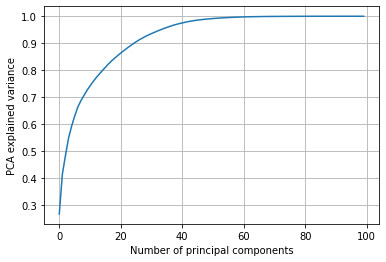

In [35]:
PCA_model = PCA(n_components = df_X.shape[1]).fit(df_X)
X_pca = PCA_model.transform(df_X)

s_pca50_ev = pd.Series(PCA_model.explained_variance_ratio_).cumsum()
s_pca50_ev.plot()
plt.grid()
plt.ylabel('PCA explained variance')
plt.xlabel('Number of principal components')

print('Explained variance from 50 PC\'s:', f'{s_pca50_ev.loc[50]:0.3f}')

Define `df_X_pca` and export together with `df_y`. 

<b> <span style="background-color: #267E41"> These form the basis for time-independent regression analyses. </span> </b>

In [36]:
df_X_pca = pd.DataFrame(X_pca[:,:50], index=df_X.index, columns=['pca'+str(i) for i in range(1, 50+1)])
df_X_pca.to_pickle('df_X_pca.pkl')
df_y.to_pickle('df_y.pkl')
print(df_X_pca.shape, df_y.shape)

(1229, 50) (1229, 6)


## Lag features - base for time series regression


#### Now we add 5 lag features based on both X and y

In [37]:
n_lag_input = 5
n_lag_output = 5

df_list = [df_X_pca]
X_pca_cols = df_X_pca.columns
y_cols = df_y.columns

for i in range(1, n_lag_input+1):
    temp_X = df_X_pca.shift(i)
    temp_X.columns = [col+'-'+str(i) for col in X_pca_cols]
    df_list.append(temp_X.copy())

for i in range(1, n_lag_output+1):
    temp_y = df_y.shift(i)
    temp_y.columns = [col+'-'+str(i) for col in y_cols]
    df_list.append(temp_y.copy())

df_X_lagged = pd.concat(df_list, axis=1, join='inner')
df_X_lagged.dropna(inplace=True)
print(df_X_lagged.shape)

df_y_lagged = df_y.loc[df_X_lagged.index]
print(df_y_lagged.shape)

(1224, 330)
(1224, 6)


Export `df_X_lagged` together with `df_y_lagged` 

<b> <span style="background-color: #267E41"> These form the basis for time-<u>dependent</u> regression analyses. </span> </b>

In [38]:
df_X_lagged.to_pickle('df_X_lagged.pkl')
df_y_lagged.to_pickle('df_y_lagged.pkl')